In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyvibdmc.analysis import *
from pyvibdmc.simulation_utilities import *
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization
from try_descriptors import *

In [2]:
def load_training(training_name):
    """If using deb_training_every argument, read the files with this."""
    with h5py.File(training_name, 'r') as f:
        cds = f['coords'][:]
        vs = f['pots'][:]
    return cds, Constants.convert(vs, "wavenumbers", to_AU=False)


def get_ml_data(ts, trainings):
    tot_x = []
    tot_v = []
    for training in trainings:
        for time in ts:
            cds, vs = load_training(f"/home/fenris/McCoy_Group/conv/ch5_dmc/ch5_training_data/ch5_training_{training}_training_{time}ts.hdf5")
            print(cds.shape)
            tot_x.append(cds.squeeze())
            tot_v.append(vs)
    tot_x = np.concatenate(tot_x)
    tot_v = np.concatenate(tot_v)
    return tot_x, tot_v


tss = np.arange(2000,10000,2000)
trainings = np.arange(9)
train_x, train_y = get_ml_data(tss, trainings)
train_x = coulomb_it(train_x)

(19971, 6, 3)
(19980, 6, 3)
(19954, 6, 3)
(19922, 6, 3)
(19937, 6, 3)
(20025, 6, 3)
(19952, 6, 3)
(19953, 6, 3)
(19924, 6, 3)
(19914, 6, 3)
(19955, 6, 3)
(19979, 6, 3)
(19951, 6, 3)
(19928, 6, 3)
(20025, 6, 3)
(19893, 6, 3)
(19997, 6, 3)
(19943, 6, 3)
(19962, 6, 3)
(19961, 6, 3)
(19950, 6, 3)
(19953, 6, 3)
(19938, 6, 3)
(19933, 6, 3)
(19974, 6, 3)
(19998, 6, 3)
(19920, 6, 3)
(19986, 6, 3)
(19970, 6, 3)
(19913, 6, 3)
(19918, 6, 3)
(19942, 6, 3)
(19983, 6, 3)
(19964, 6, 3)
(19944, 6, 3)
(19914, 6, 3)


In [4]:
def vectorize(clmat):
    tril_map = 1 - np.tril(np.ones((6,6)))
    cleanmat = np.multiply(clmat, tril_map).flatten()
    return cleanmat[cleanmat != 0]

def normalize(vec, mx, mn):
    return 2*(vec-mn)/(mx-mn) - 1

train_x = np.array([vectorize(mat) for mat in train_x])

In [8]:
train_x = normalize(train_x, 6, 0)
train_y = np.log10(train_y)

In [9]:
val_x = train_x[-10000:]
val_y = train_y[-10000:]
train_x = train_x[:-10000]
train_y = train_y[:-10000]

In [10]:
def plot_result(val_x, val_y, history, model):
    fig = plt.figure(figsize=(8,6))
    ax_loss = fig.add_subplot(111)
#    ax_data = fig.add_subplot(212)
    
    ax_loss.plot(history.history['loss'])
    ax_loss.plot(history.history['val_loss'])
    ax_loss.set_ylabel('loss')
    ax_loss.set_xlabel('epoch')
    ax_loss.legend(['train', 'test'], loc='upper right')
    
#     ax_data.scatter(val_x,val_y)
#     ax_data.scatter(val_x, model.predict(val_x), marker='|')
#     ax_data.legend(['Analytic', 'Predicted'], loc='upper right')
    
    plt.show()

In [11]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(15,)),
        Dense(128, activation=tf.nn.swish),
        Dense(128, activation=tf.nn.swish),
        Dense(128, activation=tf.nn.swish),
        Dense(1, activation=tf.nn.swish)
    ]
)

#model.load_weights('ch5_3x128.h5')

In [60]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=100000, decay_rate=0.8, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
                 loss='mse',
                 metrics=[])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 35,201
Trainable params: 35,201
Non-trainable params: 0
_________________________________________________________________


In [98]:
history = model.fit(train_x, train_y, validation_split=0.1, batch_size=32, epochs=2000)

Epoch 1/2000
19922/19922 [==============================] - 43s 2ms/step - loss: 8.4001e-06 - val_loss: 1.0522e-05
Epoch 2/2000
19922/19922 [==============================] - 42s 2ms/step - loss: 8.4090e-06 - val_loss: 9.0354e-06
Epoch 3/2000
19922/19922 [==============================] - 44s 2ms/step - loss: 8.4247e-06 - val_loss: 1.0093e-05
Epoch 4/2000
19922/19922 [==============================] - 43s 2ms/step - loss: 8.4971e-06 - val_loss: 8.6607e-06
Epoch 5/2000
19922/19922 [==============================] - 43s 2ms/step - loss: 8.3614e-06 - val_loss: 1.8162e-05
Epoch 6/2000
19922/19922 [==============================] - 43s 2ms/step - loss: 8.3252e-06 - val_loss: 1.1102e-05
Epoch 7/2000
19922/19922 [==============================] - 45s 2ms/step - loss: 8.4657e-06 - val_loss: 1.0325e-05
Epoch 8/2000
19922/19922 [==============================] - 44s 2ms/step - loss: 8.4739e-06 - val_loss: 7.9052e-06
Epoch 9/2000
19922/19922 [==============================] - 45s 2ms/step - loss:

KeyboardInterrupt: 

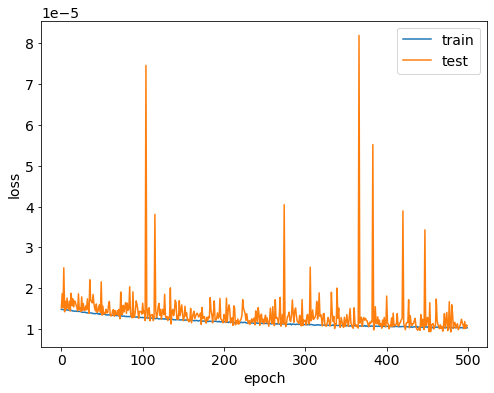

In [62]:
plot_result(val_x, val_y, history, model)

In [99]:
print("       Label        Predicted")
val_data = np.concatenate((10**np.expand_dims(val_y, axis=1), 10**model.predict(val_x)),axis=1)
print(val_data[:10])

       Label        Predicted
[[31147.18643614 31203.34765625]
 [12842.10646772 12851.1796875 ]
 [14182.77491475 14053.67675781]
 [16621.03619091 16651.640625  ]
 [49020.94538119 49192.4921875 ]
 [27204.370526   27337.48242188]
 [21711.94891946 21523.95117188]
 [34866.97892258 34829.96875   ]
 [20334.93892341 20194.65039062]
 [15353.34968456 15409.36230469]]


(-0.001, 0.05)

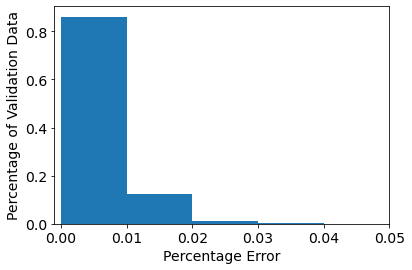

In [100]:
weights = np.ones_like(val_data[:,0]) / len(val_data[:,0])
plt.hist(np.abs(val_data[:,0]-val_data[:,1])/val_data[:,0], bins=np.arange(0,1,0.01), weights=weights)
plt.xlabel('Percentage Error')
plt.ylabel('Percentage of Validation Data')

plt.xlim((-0.001,0.05))

In [101]:
model.save_weights('ch5_3x128.h5')

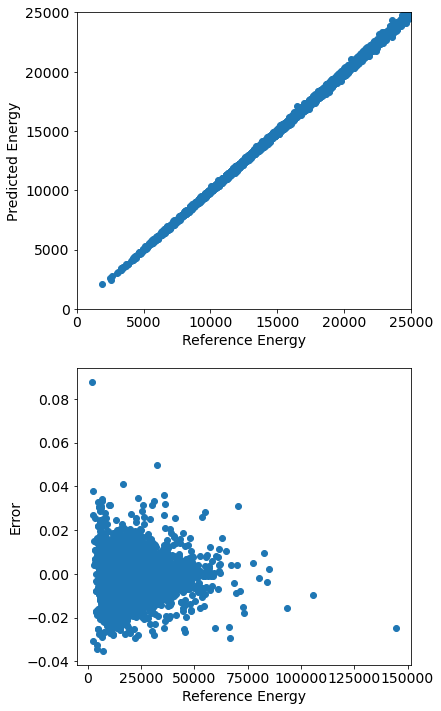

In [102]:
def plot_dis_vec(x1, x2):
    fig = plt.figure(figsize=(6,12))

    loss = fig.add_subplot(2,1,1)
    loss.scatter(x1, x2)
    loss.set_xlabel('Reference Energy')
    loss.set_ylabel('Predicted Energy')
    loss.set_xlim((0, 25000))
    loss.set_ylim((0, 25000))
    
    percent_loss = fig.add_subplot(2,1,2)
    percent_loss.scatter(x1, (x2-x1)/x1)
    percent_loss.set_xlabel('Reference Energy')
    percent_loss.set_ylabel('Error')
    #percent_loss.set_ylim((-0.2,0.2))
    #percent_loss.set_xlim((0,100))
    plt.show()
    
plot_dis_vec(val_data[:,0], val_data[:,1])

In [2]:
import os
os.getcwd()

'/home/fenris/McCoy_Group/conv/h2o_dmc'